# PCA, Clustering, and Profiles
High-level dimensionality reduction plus quick segment clustering for hotel bookings.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler



In [2]:
data_path = Path("../processed data/hotel_bookings_final.pkl")
df = pd.read_pickle(data_path)

# Ensure all features are numeric for PCA
# (some categorical columns may still be present in the saved pickle)
df = pd.get_dummies(df, drop_first=True)

# Separate features and target
X = df.drop(columns=["is_canceled"])
y = df["is_canceled"]

# Scale features for PCA stability
scaler = StandardScaler(with_mean=False)
X_scaled = scaler.fit_transform(X)



In [3]:
pca = PCA(n_components=2, random_state=42)
pca_components = pca.fit_transform(X_scaled)

explained_var = pca.explained_variance_ratio_
print("Explained variance ratios:", explained_var)
print("Cumulative variance (2 components):", explained_var.sum())


Explained variance ratios: [0.02139879 0.01629986]
Cumulative variance (2 components): 0.03769865641265413


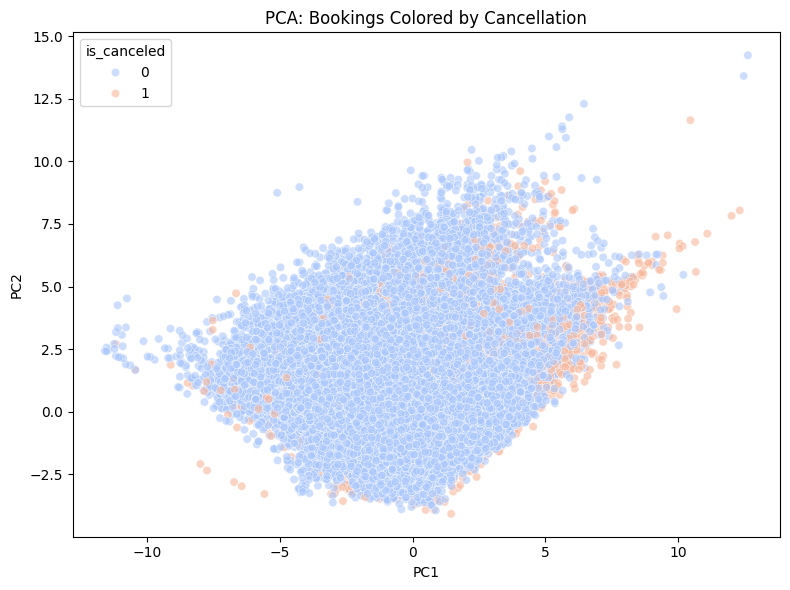

In [4]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=pca_components[:,0], y=pca_components[:,1], hue=y, palette="coolwarm", alpha=0.6)
plt.title("PCA: Bookings Colored by Cancellation")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="is_canceled")
plt.tight_layout()
plt.show()



In [5]:
# PCA loadings to see which features drive each component
loadings = pd.DataFrame(pca.components_, columns=X.columns, index=["PC1","PC2"])

# Top absolute loadings per component
for pc in loadings.index:
    top_features = loadings.loc[pc].abs().sort_values(ascending=False).head(10)
    print(f"\nTop contributors for {pc}:")
    print(top_features)




Top contributors for PC1:
revenue                       0.304764
has_agent_flag                0.272913
distribution_channel_TA/TO    0.256332
adr                           0.255714
total_guests                  0.247354
total_stay_nights             0.235960
market_segment_Online TA      0.232363
adults                        0.223072
stays_in_week_nights          0.218511
market_segment_Corporate      0.201436
Name: PC1, dtype: float64

Top contributors for PC2:
distribution_channel_Direct    0.320276
market_segment_Direct          0.313505
distribution_channel_TA/TO     0.310956
hotel_Resort Hotel             0.249188
market_segment_Online TA       0.218321
revenue                        0.216425
has_agent_flag                 0.198588
has_parking                    0.179175
required_car_parking_spaces    0.178591
meal_SC                        0.167527
Name: PC2, dtype: float64


In [6]:
# Save PCA components for downstream visualization
output_dir = Path("../processed data")
output_dir.mkdir(parents=True, exist_ok=True)

pca_df = pd.DataFrame(pca_components, columns=["PC1","PC2"])
pca_df["is_canceled"] = y.reset_index(drop=True)

pca_df.to_pickle(output_dir / "hotel_pca_components.pkl")
loadings.to_pickle(output_dir / "hotel_pca_loadings.pkl")

pca_df.head()



,PC1,PC2,is_canceled
0,-3.298194,3.684941,0
1,-3.338342,3.866058,0
2,-3.705826,2.808187,0
3,-2.795575,0.345518,0
4,0.464454,-0.688378,0


In [7]:
from sklearn.cluster import KMeans

# Simple 3-cluster pass on the 2D PCA space to segment bookings
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
clusters = kmeans.fit_predict(pca_components)

pca_df["cluster"] = clusters
pca_df.head()


,PC1,PC2,is_canceled,cluster
0,-3.298194,3.684941,0,1
1,-3.338342,3.866058,0,1
2,-3.705826,2.808187,0,1
3,-2.795575,0.345518,0,1
4,0.464454,-0.688378,0,2


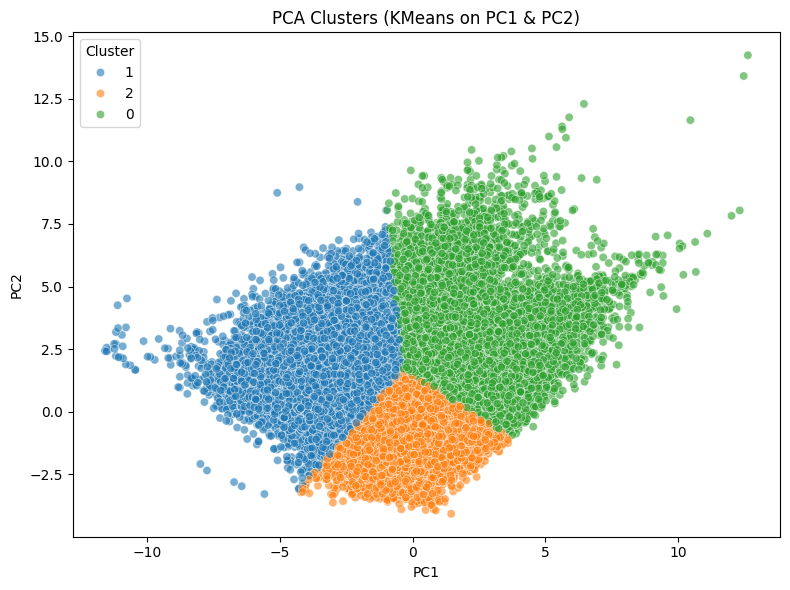

In [8]:
plt.figure(figsize=(8,6))
sns.scatterplot(
    x=pca_df["PC1"],
    y=pca_df["PC2"],
    hue=pca_df["cluster"].astype(str),
    palette="tab10",
    alpha=0.6
)
plt.title("PCA Clusters (KMeans on PC1 & PC2)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


In [9]:
# Summarize top positive/negative loadings for each component
n_top = 6
for pc in ["PC1", "PC2"]:
    comp = loadings.loc[pc]
    top_pos = comp.sort_values(ascending=False).head(n_top)
    top_neg = comp.sort_values().head(n_top)
    print(f"\n{pc} — top +loadings:")
    print(top_pos)
    print(f"\n{pc} — top -loadings:")
    print(top_neg)




PC1 — top +loadings:
revenue                       0.304764
has_agent_flag                0.272913
distribution_channel_TA/TO    0.256332
adr                           0.255714
total_guests                  0.247354
total_stay_nights             0.235960
Name: PC1, dtype: float64

PC1 — top -loadings:
market_segment_Corporate         -0.201436
is_repeated_guest                -0.174631
country_PRT                      -0.169747
distribution_channel_Direct      -0.157643
market_segment_Direct            -0.130550
previous_bookings_not_canceled   -0.124698
Name: PC1, dtype: float64

PC2 — top +loadings:
distribution_channel_Direct    0.320276
market_segment_Direct          0.313505
hotel_Resort Hotel             0.249188
revenue                        0.216425
has_parking                    0.179175
required_car_parking_spaces    0.178591
Name: PC2, dtype: float64

PC2 — top -loadings:
distribution_channel_TA/TO   -0.310956
market_segment_Online TA     -0.218321
has_agent_flag          

In [10]:
# Quick cluster profile on a few interpretable (scaled) features
key_cols = [
    "lead_time",
    "adr",
    "total_of_special_requests",
    "previous_cancellations",
    "booking_changes",
    "deposit_type_Non Refund",
    "deposit_type_Refundable",
    "market_segment_Online TA",
    "market_segment_Groups",
    "distribution_channel_Online TA",
]

present_cols = [c for c in key_cols if c in df.columns]
cluster_profile = (
    pd.concat([df.reset_index(drop=True), pca_df[["cluster"]]], axis=1)
      .groupby("cluster")[present_cols]
      .mean()
)

print("Cluster profile (scaled feature means):")
cluster_profile


Cluster profile (scaled feature means):


,lead_time,adr,total_of_special_requests,previous_cancellations,booking_changes,deposit_type_Non Refund,deposit_type_Refundable,market_segment_Online TA,market_segment_Groups
cluster,,,,,,,,,
0,0.394117,0.982057,0.187964,-0.066226,0.178571,0.001141,0.000480,0.631228,0.012727
1,-0.530392,-0.539462,-0.358310,0.223015,0.230302,0.010372,0.004950,0.029878,0.118569
2,0.045293,-0.134016,0.054854,-0.049871,-0.128020,0.015680,0.000279,0.755050,0.050556


In [11]:
# Save enriched PCA outputs
output_dir = Path("../processed data")
output_dir.mkdir(parents=True, exist_ok=True)

pca_df.to_pickle(output_dir / "hotel_pca_components_with_clusters.pkl")
cluster_profile.to_pickle(output_dir / "hotel_pca_cluster_profile.pkl")

print("Saved:")
print("- hotel_pca_components_with_clusters.pkl")
print("- hotel_pca_cluster_profile.pkl")


Saved:
- hotel_pca_components_with_clusters.pkl
- hotel_pca_cluster_profile.pkl
